Monolayer unit domain. Piecewise PML. Convergence

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


/home/srecondo/miniconda3/envs/cleaned-fenicsx/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Domain, PML, refinement and physical configurations

In [2]:
# Define element size for the mesh refinement
h_i = [0.125,
    0.0625,
    0.0625 / 2,
    0.0625 / 4,
    0.0625 / 8]


# Domain configuration
Lx = 1 # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1 # kg/m^3 
vel_media_1 = 1   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0
def vel_function(x):    
    return vel_media_1+x[0]*0

# PML configuration
pml_thickness = Lx/4
sigma_0 = 2.  #100/Lx

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [3]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-7, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-2.5j)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [4]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real mayor que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))
        else:
            omega_value=None

    # Seleccionar el n-ésimo eigenvalor filtrado
    omega_value, vrA = eigenvalues[selected_index]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

piecewise

In [5]:
get_exact_pml_eigenvalue=lambda n: ((n+1) * np.pi * vel_media_1 - 1j * pml_thickness*sigma_0) / (Lx + pml_thickness)

exact = [None] * 5 
for j in np.arange(0, 5,1):
    exact[j] = get_exact_pml_eigenvalue(j)


In [6]:
# Define piecewise sigma function
sigma_x_piecewise=lambda x: conditional(x[0] > Lx, sigma_0, 0.0)
# Initialize lists to store the approximated eigenpairs
approx_piecewise_P1_P0 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P2_P1 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P4_P3 = [[0 for _ in range(5)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for piecewise PML
    [solver_piecewise_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_piecewise)
    [solver_piecewise_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_piecewise)
    [solver_piecewise_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_piecewise)
    [solver_piecewise_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_piecewise)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_piecewise_P1_P0[i][j] = get_approx_eigenpair(solver_piecewise_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0)[0]
        approx_piecewise_P2_P1[i][j] = get_approx_eigenpair(solver_piecewise_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1)[0]
        approx_piecewise_P3_P2[i][j] = get_approx_eigenpair(solver_piecewise_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2)[0]
        approx_piecewise_P4_P3[i][j] = get_approx_eigenpair(solver_piecewise_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3)[0]


In [7]:
def agrupar_por_posicion(lista_de_listas):
    return [list(grupo) for grupo in zip(*lista_de_listas)]

def borrar_filas_incompletas(lista_de_listas, longitud_minima):
    return [fila for fila in lista_de_listas if len(fila) >= longitud_minima]

# Uso de la función
longitud_minima = len(h_i)
groups_P1_P0=agrupar_por_posicion(approx_piecewise_P1_P0)
groups_P2_P1=agrupar_por_posicion(approx_piecewise_P2_P1)
groups_P3_P2=agrupar_por_posicion(approx_piecewise_P3_P2)
groups_P4_P3=agrupar_por_posicion(approx_piecewise_P4_P3)

groups_P1_P0 = borrar_filas_incompletas(groups_P1_P0, longitud_minima)
groups_P2_P1 = borrar_filas_incompletas(groups_P2_P1, longitud_minima)
groups_P3_P2 = borrar_filas_incompletas(groups_P3_P2, longitud_minima)
groups_P4_P3 = borrar_filas_incompletas(groups_P4_P3, longitud_minima)

In [8]:
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P4_P2=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P4_P2=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P4_P2=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P4_P2=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) 


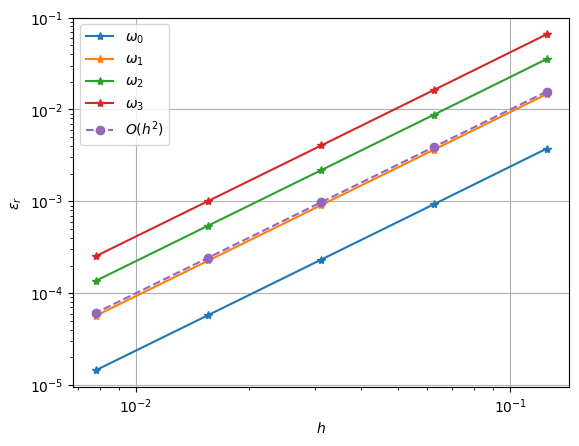

In [9]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P1_P0, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P1_P0, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P1_P0, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P1_P0, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**2 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{2}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
# plt.title(f"[P{problem.FE['p']._degree}-P{problem.FE['v']._degree}] - PML eigenvalues' convergence. {pml_type} profile.")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

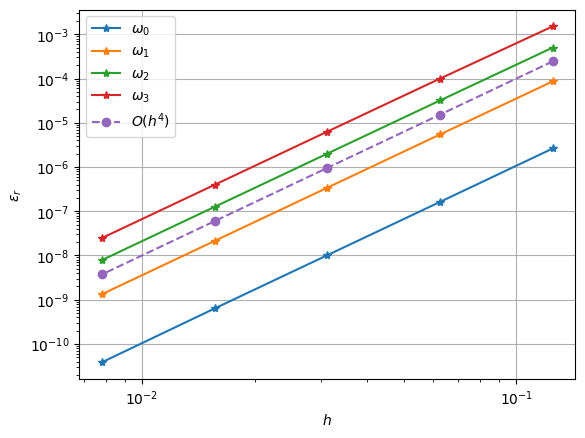

In [10]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P2_P1, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P2_P1, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P2_P1, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P2_P1, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**4 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{4}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()


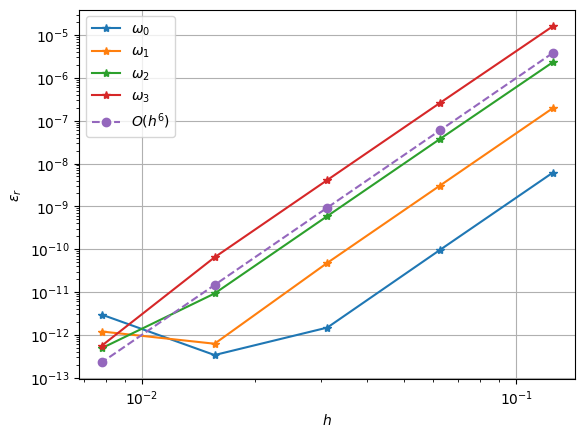

In [11]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P3_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P3_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P3_P2, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P3_P2, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**6 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{6}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

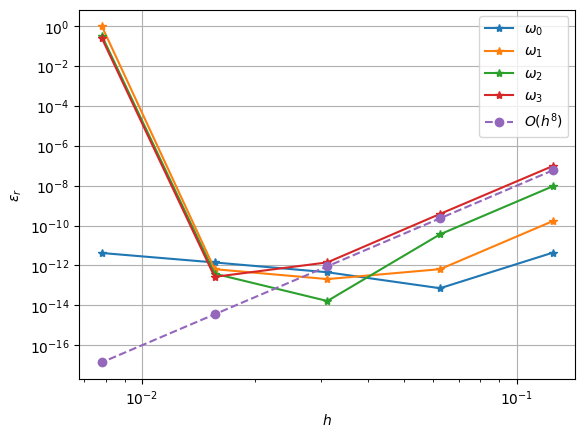

In [12]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P4_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P4_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P4_P2, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P4_P2, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**8 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{8}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()